<a href="https://colab.research.google.com/github/ranjita782/python-projects/blob/main/ola_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 194oiYUx917jxPLvqnFPtPDi3n09Ullkj

Downloading...
From: https://drive.google.com/uc?id=194oiYUx917jxPLvqnFPtPDi3n09Ullkj
To: /content/ola.csv
100% 1.13M/1.13M [00:00<00:00, 22.4MB/s]


In [2]:
#Header files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import chi2,chi2_contingency,f_oneway,kruskal,shapiro
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [51]:
# Import the dataset
df=pd.read_csv('ola.csv')

In [52]:
#2.1 Drop any irrelevant column present in the dataset.
df = df.drop(columns=['Unnamed: 0'])
df.drop(['LastWorkingDate', 'MMM-YY','Dateofjoining'], axis=1, inplace=True)
#Check the shape of the dataset after dropping the column.
df.shape

(19104, 10)

In [53]:
numerical_cols=df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
datetime_cols = df.select_dtypes(include=['datetime']).columns

In [54]:
aggregated_df = df.groupby('Driver_ID').agg({
    'Age': 'mean',
    'City': lambda x: x.mode()[0],    # Most frequent
    'Education_Level': lambda x: x.mode()[0],  # Most frequent education level
    'Income': 'mean',
    'Joining Designation': lambda x: x.mode()[0],  # Most frequent designation
    'Grade': 'mean',
    'Quarterly Rating': 'mean'
}).reset_index()

In [55]:
aggregated_df = pd.DataFrame(aggregated_df)
merged_df = df.merge(aggregated_df, on='Driver_ID', suffixes=('', '_aggregated'),how='left')
columns_to_drop = ['Age', 'City','Income','Education_Level','Joining Designation', 'Grade', 'Quarterly Rating']
df= merged_df.drop(columns=columns_to_drop)
df=pd.DataFrame(df)

The aggregation based on Driver_ID was done for attaining the uniqueness in  the  dataset.It also helped to identify consistent behaviors and patterns of their working.We were able to merge rows that have the same Driver_ID based on our desired aggregation rules.The groupby method aggregated the data by Driver_ID, keeping the mean of Income, the mode of Grade and the Quarterly_Rating columns.

In [56]:
# Created a dictionary to map old column names to new ones by removing the '_aggregated' suffix
rename_columns = {col: col.replace('_aggregated', '') for col in df.columns if '_aggregated' in col}
df.rename(columns=rename_columns, inplace=True)
print(df.columns)


Index(['Driver_ID', 'Gender', 'Total Business Value', 'Age', 'City',
       'Education_Level', 'Income', 'Joining Designation', 'Grade',
       'Quarterly Rating'],
      dtype='object')


In [57]:
# One-Hot Encoding for Categorical variable
df = pd.get_dummies(df, columns=['City'])
# Assuming df is your DataFrame and you want to convert all Boolean columns
boolean_columns = df.select_dtypes(include=[bool]).columns
df[boolean_columns] = df[boolean_columns].astype(int)

In [58]:
# Scalarization using standard scaler
numerical_data = df[numerical_cols]
from sklearn.preprocessing import StandardScaler

# Standardize the numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

In [60]:
#Imputation done using kNN
from sklearn.impute import KNNImputer

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(numerical_data_scaled)
imputed_df = pd.DataFrame(imputed_data, columns=numerical_cols)
imputed_df = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=numerical_cols)
df[numerical_cols] = imputed_df

In [61]:
# 4.3 Function to detect and handle outliers using IQR method
def handle_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

# List of numerical columns to check for outliers
numerical_cols = df.select_dtypes(include=['number']).columns

# Handle outliers for each numerical column
for column in numerical_cols:
    handle_outliers(column)

In [62]:
df.to_csv('newola.csv', index=False)

In [63]:
df=pd.read_csv('newola.csv')

In [67]:
# Calculate change within each Driver_ID group
df['Income_Change'] = df.groupby('Driver_ID')['Income'].diff()
df['Declining_Income'] = (df['Income_Change'] < 0).astype(int)

df['TBV_Change'] = df.groupby('Driver_ID')['Total Business Value'].diff()
df['Declining_TBV'] = (df['TBV_Change'] < 0).astype(int)

df['QR_Change'] = df.groupby('Driver_ID')['Quarterly Rating'].diff()
df['Declining_Quarterly_Rating'] = (df['QR_Change'] < 0).astype(int)


In [68]:
# Step 3: Identify drivers with declining metrics before churn
df['Likely_to_Churn'] = ((df['Declining_Income'] == 1) |
                         (df['Declining_TBV'] == 1) |
                         (df['Declining_Quarterly_Rating'] == 1)).astype(int)

df['Final_Churn_Prediction'] = df.apply(lambda x: 1 if  x['Likely_to_Churn'] == 1 else 0, axis=1)

In [69]:
# Impute with mean or median
df['Income_Change'].fillna(df['Declining_Income'].mean(), inplace=True)
df['TBV_Change'].fillna(df['Declining_TBV'].mean(), inplace=True)
df['QR_Change'].fillna(df['Declining_Quarterly_Rating'].mean(), inplace=True)


In [70]:
df = df.drop_duplicates(subset='Driver_ID', keep='last')

In [71]:
df['Final_Churn_Prediction'].groupby(df['Final_Churn_Prediction']).count()

,Final_Churn_Prediction
Final_Churn_Prediction,
0,1609
1,772


In [72]:
df['Income_Change'].unique()

array([0.])

In [73]:
df['Final_Churn_Prediction'].count()

2381

In [74]:
df.isna().sum()

,0
Driver_ID,0
Gender,0
Total Business Value,0
Age,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Quarterly Rating,0
City_C1,0


In [75]:
# Columns that should remain integers
int_cols = ['Age','Driver_ID','Gender','Education_Level','Grade','Joining Designation', 'Quarterly Rating']

# Convert them back to integer type
df[int_cols] = df[int_cols].astype('int')


In [76]:
# Check if any row has NaN values
rows_with_nan = df[df.isna().any(axis=1)]
(rows_with_nan)

,Driver_ID,Gender,Total Business Value,Age,Education_Level,Income,Joining Designation,Grade,Quarterly Rating,City_C1,...,City_C8,City_C9,Income_Change,Declining_Income,TBV_Change,Declining_TBV,QR_Change,Declining_Quarterly_Rating,Likely_to_Churn,Final_Churn_Prediction


In [83]:
#Splitting of data
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('Final_Churn_Prediction', axis=1)
y = df['Final_Churn_Prediction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
# Hyperpatrameter tuning 1st method
# Oversampling using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


Applyied the Synthetic Minority Over-sampling Technique (SMOTE) to create new samples for the minority class so that class imbalance is manipulated well.

In [85]:
# Classification report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initializing and training the model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_res, y_res)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       477
           1       1.00      1.00      1.00       238

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



In [92]:
# ROC-AUC score
y_proba = rf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_score}")


ROC-AUC Score: 1.0


In [86]:
# Hyperpatrameter tuning 2nd method
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [87]:
from imblearn.under_sampling import RandomUnderSampler

# Applying undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


Randomly removed samples from the majority class to balance the dataset.

In [88]:
from imblearn.combine import SMOTETomek

# Applying hybrid sampling (SMOTE + Tomek links)
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


 Balanced the dataset by applying both oversampling to the minority class and undersampling to the majority class.

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with class_weight='balanced'
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Utilized models that support class_weight parameters to give more importance to the minority class.

In [90]:
import xgboost as xgb

model = xgb.XGBClassifier(scale_pos_weight=(len(y_train) / sum(y_train)), random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

To address class imbalance, we used resampling methods like SMOTE (oversampling), random undersampling and hybrid techniques like SMOTETomek. Additionally, we adjusted algorithms by setting class_weight='balanced'. Lastly, ensemble methods like Bagging (Random Forest) as well as Boosting (XGBoost) were modelled to help improve predictions for imbalanced datasets.

In [91]:
# Classification report based on 2nd method
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predict on test data
y_pred = model.predict(X_test)

# Classification report for precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# ROC-AUC score
y_proba = model.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_score}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       477
           1       1.00      1.00      1.00       238

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715

[[477   0]
 [  0 238]]
ROC-AUC Score: 1.0


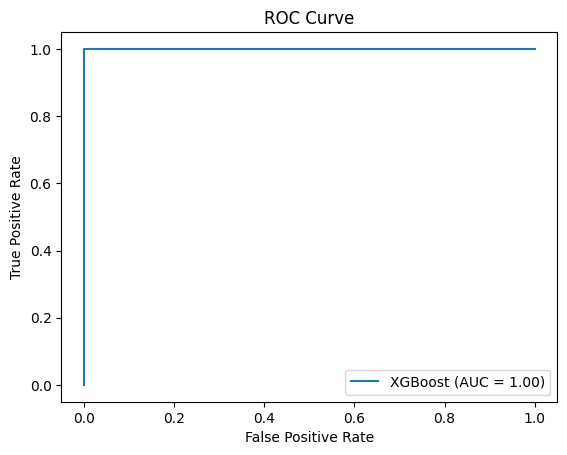

In [101]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [106]:
df=pd.read_csv('newola.csv')


In [107]:
# Calculate change within each Driver_ID group
df['Income_Change'] = df.groupby('Driver_ID')['Income'].diff()
df['Declining_Income'] = (df['Income_Change'] < 0).astype(int)

df['TBV_Change'] = df.groupby('Driver_ID')['Total Business Value'].diff()
df['Declining_TBV'] = (df['TBV_Change'] < 0).astype(int)

df['QR_Change'] = df.groupby('Driver_ID')['Quarterly Rating'].diff()
df['Declining_Quarterly_Rating'] = (df['QR_Change'] < 0).astype(int)


In [108]:
# Step 3: Identify drivers with declining metrics before churn
df['Likely_to_Churn'] = ((df['Declining_Income'] == 1) |
                         (df['Declining_TBV'] == 1) |
                         (df['Declining_Quarterly_Rating'] == 1)).astype(int)

df['Final_Churn_Prediction'] = df.apply(lambda x: 1 if  x['Likely_to_Churn'] == 1 else 0, axis=1)

In [109]:
# Impute with mean or median
df['Income_Change'].fillna(df['Declining_Income'].mean(), inplace=True)
df['TBV_Change'].fillna(df['Declining_TBV'].mean(), inplace=True)
df['QR_Change'].fillna(df['Declining_Quarterly_Rating'].mean(), inplace=True)


In [110]:
df = df.drop_duplicates(subset='Driver_ID', keep='last')

In [111]:
df['Final_Churn_Prediction'].groupby(df['Final_Churn_Prediction']).count()

,Final_Churn_Prediction
Final_Churn_Prediction,
0,1609
1,772


In [112]:
# Columns that should remain integers
int_cols = ['Age','Driver_ID','Gender','Education_Level','Grade','Joining Designation', 'Quarterly Rating']

# Convert them back to integer type
df[int_cols] = df[int_cols].astype('int')


In [113]:
#Splitting of data
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('Final_Churn_Prediction', axis=1)
y = df['Final_Churn_Prediction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [115]:
#Use GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy',error_score='raise')

# Fit the model on training data
rf_grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Parameters GridSearch: {rf_grid_search.best_params_}")

Best Parameters GridSearch: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [116]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on training data
xgb_grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Parameters xgb: {xgb_grid_search.best_params_}")


Best Parameters xgb: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [117]:
# Best hyperparameters
print(f"Best Parameters GridSearch: {rf_grid_search.best_params_}")

Best Parameters GridSearch: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [118]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Best hyperparameters for XGBoost
xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

# Fit XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate on test set
xgb_predictions = xgb_model.predict(X_test)

# Performance metrics for XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))


XGBoost Accuracy: 1.0
XGBoost Confusion Matrix:
 [[313   0]
 [  0 164]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00       164

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477



Confusion Matrix: All 283 true negatives (class 0) and 194 true positives (class 1) were correctly predicted.
Precision, Recall, and F1-Score: All are 1.00, indicating that the model has made no mistakes in predicting either class.
Accuracy: 1.00 (100% accuracy), which means the model predicted every instance in the test set correctly.

In [119]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

# Define the XGBoost model with the best hyperparameters
xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

# Set up StratifiedKFold cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation, scoring by accuracy
cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')

# Display the cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation of accuracy:", cv_scores.std())


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0
Standard deviation of accuracy: 0.0


XGBoost AUC-ROC: 1.0


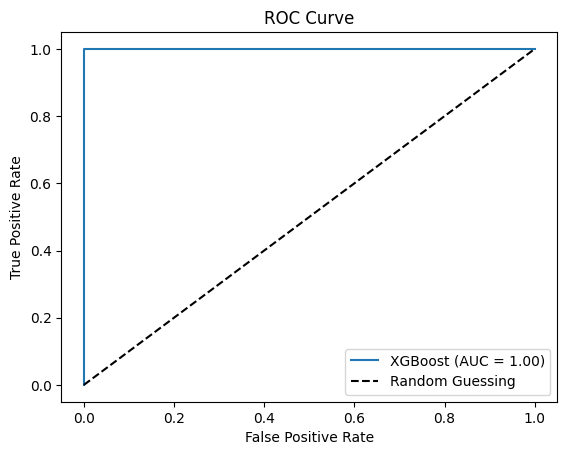

In [120]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
xgb_model.fit(X_train, y_train)

# Evaluate on test set
xgb_predictions = xgb_model.predict(X_test)

# Predict the probabilities for the test set
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]  # Get the probability for class 1

# Compute the AUC-ROC score
xgb_auc = roc_auc_score(y_test, xgb_probabilities)
print("XGBoost AUC-ROC:", xgb_auc)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, xgb_probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


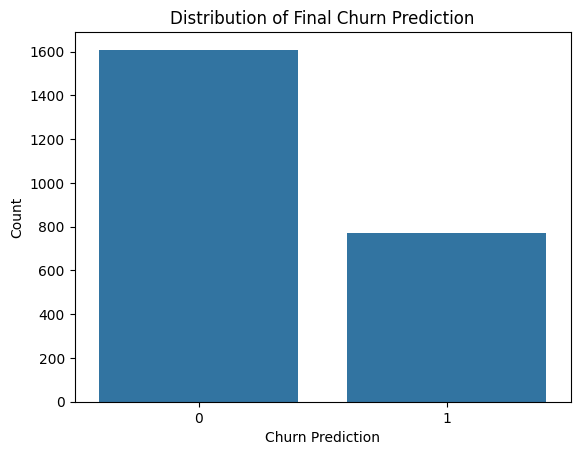

In [102]:
# Plotting the distribution of the target variable
sns.countplot(x='Final_Churn_Prediction', data=df)
plt.title('Distribution of Final Churn Prediction')
plt.xlabel('Churn Prediction')
plt.ylabel('Count')
plt.show()


In [104]:
# Assuming rf is the trained Random Forest model
importances = rf.feature_importances_
feature_names = X_train.columns  # Replace with your feature names


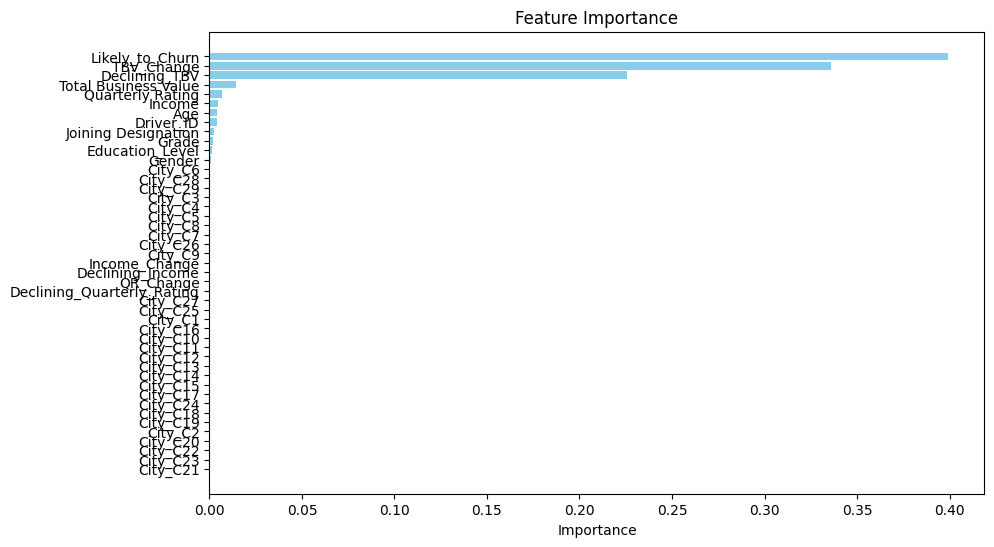

In [105]:
# Create a DataFrame for finding feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()


Feature Importance:

Likely_to_Churn is the most significant feature, indicating that the churn prediction label plays a critical role in the model's performance. This aligns with the fact that churn itself is the target variable or closely related to the target.

TBV_Change (Declining Total Business Value) is another highly influential feature. This suggests that a decline in a driver's total business value is strongly associated with churn.

Quarterly Rating also holds importance, meaning that a driver's performance rating has a significant impact on churn prediction. If their rating drops, they are likely at higher risk of leaving.